In [29]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from minisom import MiniSom

SEED = 42
random.seed(a=SEED)
np.random.seed(seed=SEED)

base_df: pd.DataFrame = pd.read_csv(filepath_or_buffer="data_2.csv", index_col=0)

In [30]:
# only numeric columns allowed!
base_df = base_df.drop(columns=["industry"])
columns = base_df.columns
print(columns)

Index(['revenues', 'ebit', 'employees', 'market_cap', 'outstanding_shares',
       'stock_price'],
      dtype='object')


In [31]:
som_df: pd.DataFrame = base_df.copy()
som_df.dropna(axis=0, inplace=True)

data = (som_df - np.mean(a=som_df, axis=0)) / np.std(a=som_df, axis=0)
data = data.values
data

array([[ 1.83476579,  0.68198303, -0.76107824,  1.69660281, -0.04021906,
         0.34380581],
       [ 1.42910904,  1.19280445, -0.36611654,  1.40785156, -0.04070878,
         0.71219922],
       [ 1.10781586,  0.41474107,  0.21872217,  1.03931004, -0.04116862,
         1.1632106 ],
       ...,
       [ 0.08031756,  0.7242307 ,  0.24644958,  1.60042957, -0.03799515,
        -0.53488283],
       [-0.16721186,  0.22066092, -0.9511671 , -0.373517  , -0.04166114,
         0.41300417],
       [-0.20080152,  0.14344032, -0.89390797,  0.46991381, -0.02214662,
        -1.17813809]])

In [32]:
x_neurons = 16
y_neurons = 16
som = MiniSom(
    x=x_neurons,
    y=y_neurons,
    input_len=columns.shape[0], #num features
    sigma=1.5,
    learning_rate=0.5,
    random_seed=SEED,
    neighborhood_function="gaussian",
    topology="hexagonal",
)

In [33]:
som.train(data=data, num_iteration=30000, verbose=True)

 [  1664 / 30000 ]   6% - 0:00:03 left 

 [ 30000 / 30000 ] 100% - 0:00:00 left 
 quantization error: 0.340576485789834


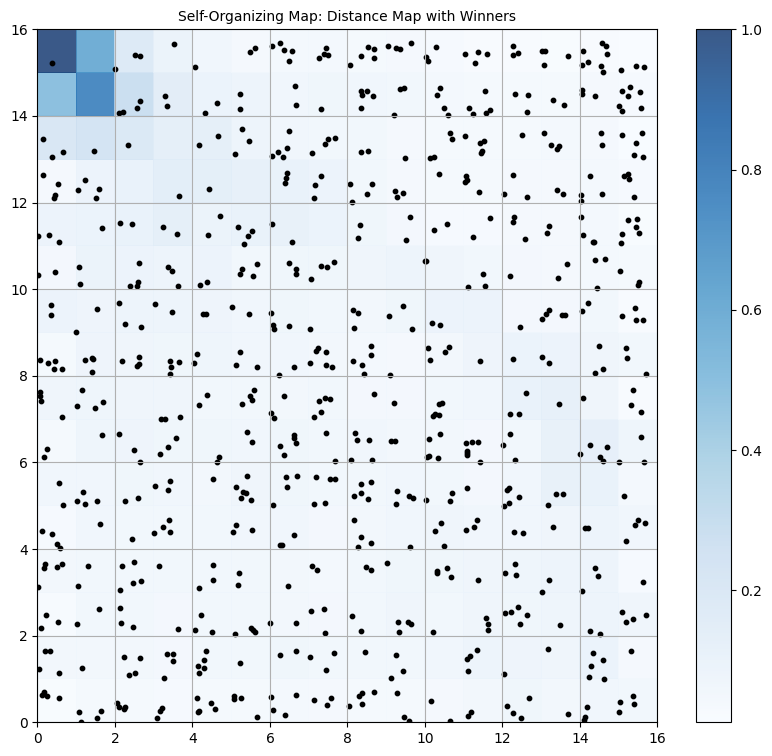

In [34]:
# colors = ['C0', 'C1', 'C2']
w_x, w_y = zip(*[som.winner(x=d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

w_x_noise = w_x + (np.random.rand(len(w_x)) * 0.7)
w_y_noise = w_y + (np.random.rand(len(w_y)) * 0.7)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap="Blues", alpha=0.8)
plt.colorbar()

plt.scatter(
    x=w_x_noise,
    y=w_y_noise,
    s=10,
    c="black",
)

plt.grid()
plt.title(label='Self-Organizing Map: Distance Map with Winners', fontsize=10)
plt.savefig("figures/som_distance_map_with_winners.png")
plt.show()

Error treshold: 0.9179530546137112


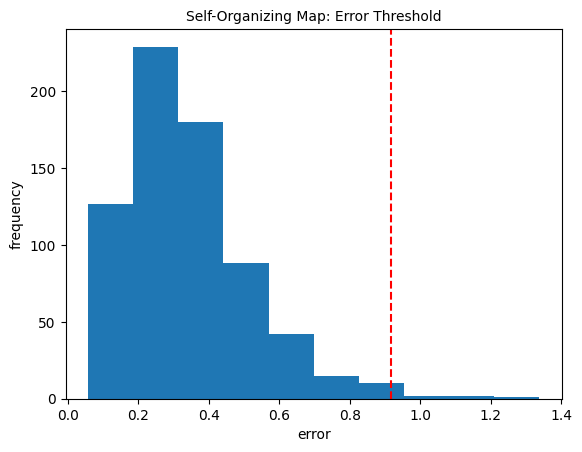

In [41]:
outliers_percentage = 0.06

quantization_errors = np.linalg.norm(som.quantization(data) - data, axis=1)
error_treshold = np.percentile(quantization_errors, 
                               100*(1-outliers_percentage)+5)

print('Error treshold:', error_treshold)

is_outlier = quantization_errors > error_treshold

plt.hist(x=quantization_errors)
plt.axvline(x=error_treshold, color='r', linestyle='--')
plt.xlabel(xlabel='error')
plt.ylabel(ylabel='frequency')
plt.title(label='Self-Organizing Map: Error Threshold', fontsize=10)
plt.savefig("figures/som_frequency_error.png")
plt.show()

In [46]:
# add is_outlier to the dataframe som_df
som_df["is_outlier"] = is_outlier
som_df.head()

,revenues,ebit,employees,market_cap,outstanding_shares,stock_price,is_outlier
0,9.894661e+10,3.368791e+10,39161.284575,8.610166e+11,8.920990e+09,98.094205,False
2,8.783573e+10,4.223690e+10,86764.936060,7.737738e+11,6.672160e+09,120.558326,False
3,7.903555e+10,2.921541e+10,157253.941191,6.624233e+11,4.560541e+09,148.060378,False
4,7.531216e+10,3.333325e+10,85562.800295,6.352531e+11,1.253771e+10,50.603175,False
5,7.804663e+10,4.267939e+10,1386.769715,8.637577e+11,4.880180e+09,181.516603,False


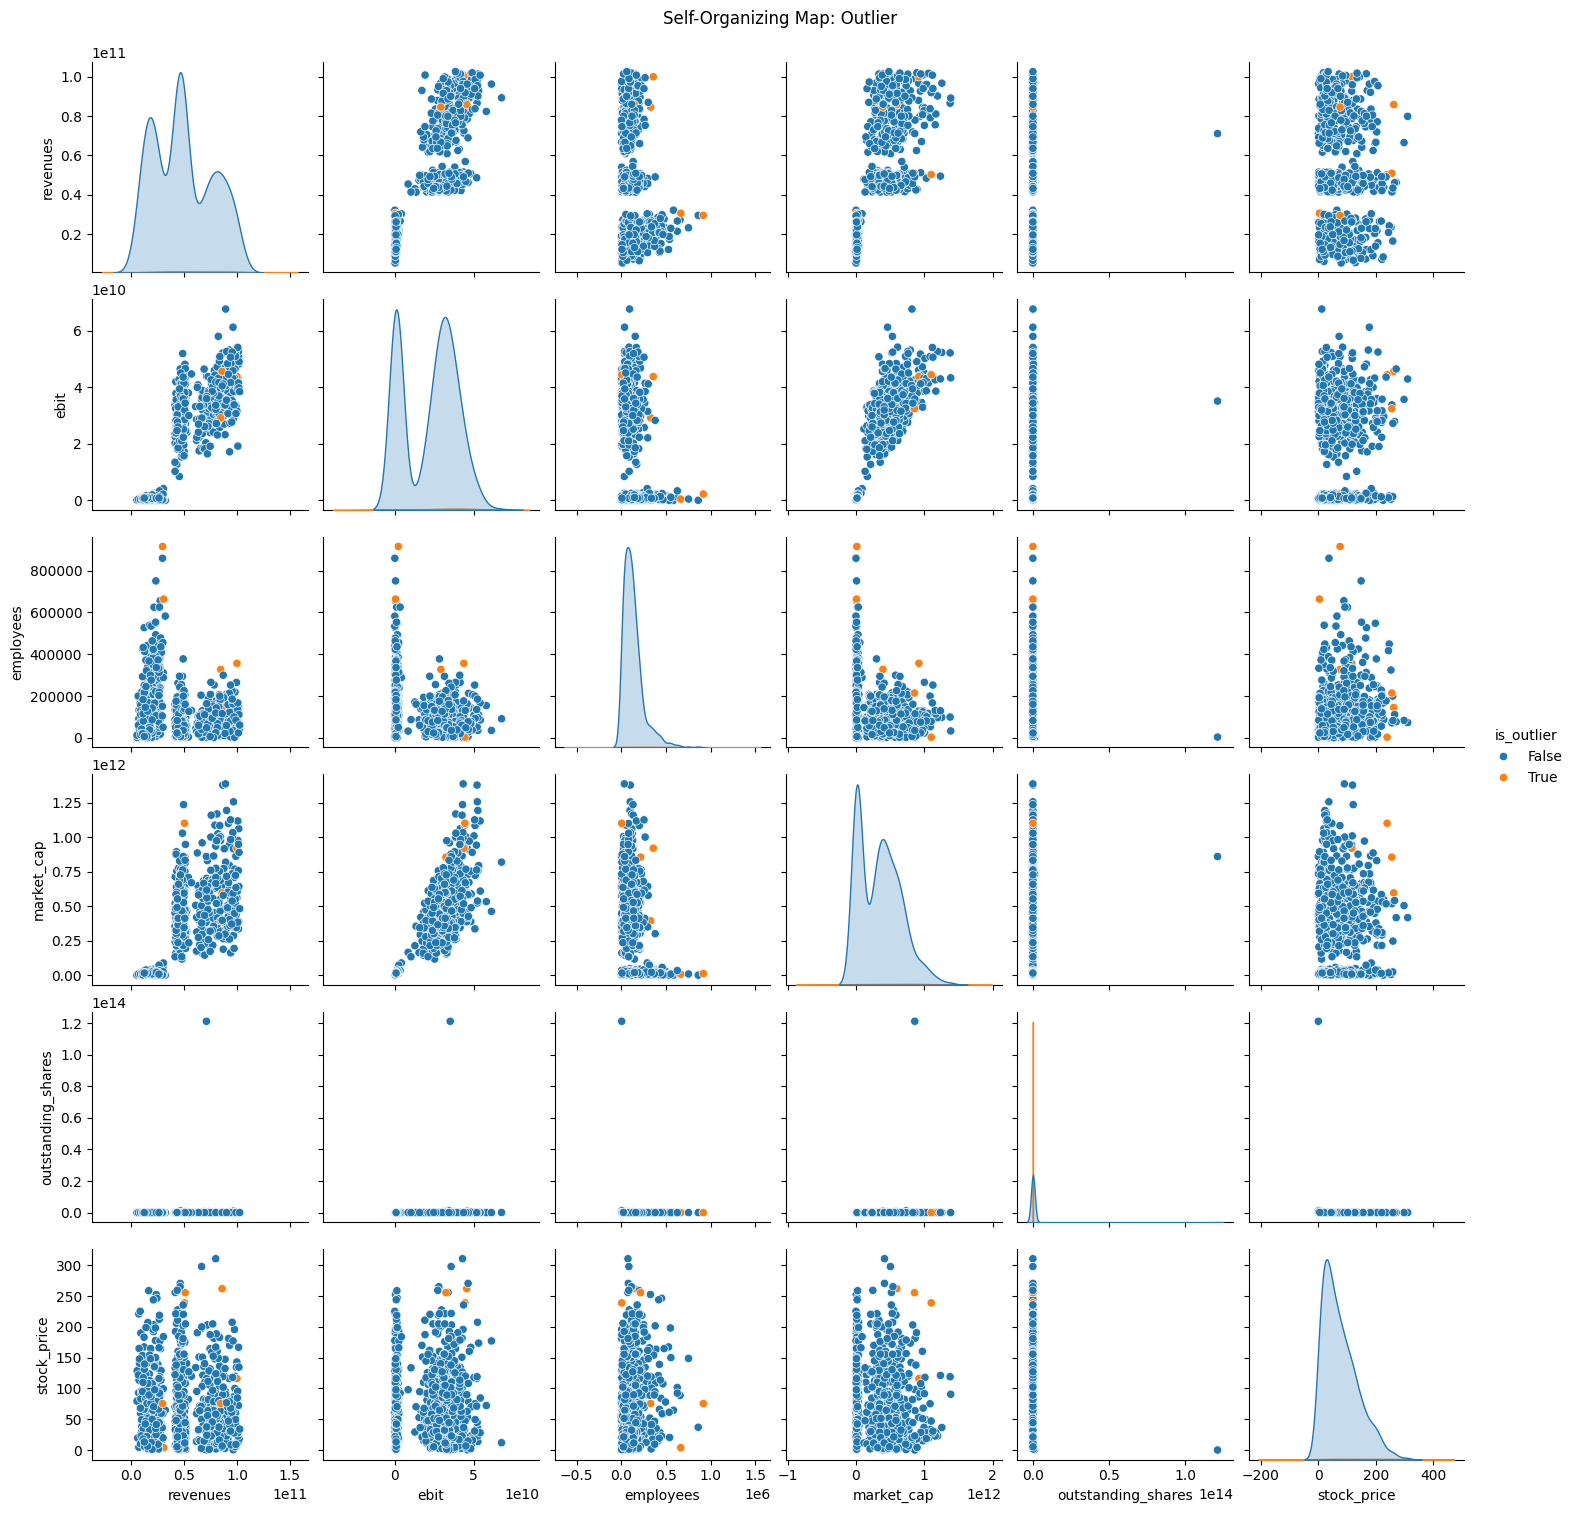

In [47]:
# pairplot the som_df with seaborn and use the is_outlier array to color the points in the pairplot
g = sns.pairplot(
    data=som_df,
    hue="is_outlier",
)
g.fig.suptitle(t="Self-Organizing Map: Outlier", y=1.01) # y= some height>1
plt.savefig("figures/som_outlier_detection.png")
plt.show()